In [109]:
import pandas as pd

prot_df = pd.read_csv('data/train_proteins.csv')
clin_df = pd.read_csv('data/train_clinical_data.csv')
clin_df = clin_df.rename(columns={'upd23b_clinical_state_on_medication': 'on_meds'})

clin_df['on_meds'] = clin_df['on_meds'].fillna(0)
clin_df['on_meds'] = clin_df['on_meds'].replace({'Off': 0, 'On': 1})


In [110]:
pivoted = prot_df.pivot(index="visit_id", columns="UniProt", values="NPX")

import numpy as np

# Normalize each column separately
for col in pivoted.columns:
    col_data = pivoted[col].dropna()
    mean = col_data.mean()
    std = col_data.std(ddof=1)
    pivoted[col] = (pivoted[col] - mean) / std
    
# Replace original NaN values in pivoted with 0 (mean value)
norm_prot_df = pivoted.fillna(0)


In [111]:
# Calculate mean and standard deviation of updrs_1 through updrs_4
updrs_mean = clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].mean()
updrs_std = clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].std()

norm_clin_df = pd.DataFrame()
# Normalize updrs_1 through updrs_4 and round to 3 sig figs
norm_clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']] = ((clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']] - updrs_mean) / updrs_std).round(3)
norm_prot_df = pivoted.fillna(0)

In [112]:
# Merge prot_df and clin_df on visit_id
merged_df = pd.merge(clin_df, norm_prot_df, on='visit_id')

# Drop any rows with NaN values
merged_df_no_nan = merged_df.dropna()

# Select only numeric columns
merged_df_no_nan_numeric = merged_df_no_nan.select_dtypes(include=np.number)


In [115]:
# Count the number of NaN values in each column of merged_df
nan_counts = merged_df.isna().sum().sort_values()

# Print the result
print(nan_counts)


visit_id      0
P19823        0
P19827        0
P20774        0
P20933        0
           ... 
P04211        0
P02766        0
Q9Y6R7        0
updrs_3      10
updrs_4     499
Length: 235, dtype: int64


In [116]:

for patient in merged_df.patient_id.unique():
    # Select the patient dataset and make a copy
    patient_data = merged_df[merged_df.patient_id == patient].copy()

    # Fill the NaN values with forward fill, backward fill, and zero
    patient_data.fillna(method='ffill', inplace=True)
    patient_data.fillna(method='bfill', inplace=True)
    patient_data.fillna(0, inplace=True)

    merged_df[merged_df['patient_id']==patient] = patient_data

In [141]:
merged_df.columns

Index(['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2',
       'updrs_3', 'updrs_4', 'on_meds', 'O00391', 'O00533',
       ...
       'Q9HDC9', 'Q9NQ79', 'Q9NYU2', 'Q9UBR2', 'Q9UBX5', 'Q9UHG2', 'Q9UKV8',
       'Q9UNU6', 'Q9Y646', 'Q9Y6R7'],
      dtype='object', length=235)

In [123]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#keep everything except the first 8 columns (non-protein data)
feature_columns = merged_df.columns[8:]
target_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

X = merged_df[feature_columns]
y = merged_df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

n_estimators_values = [50, 100, 150, 200, 500, 1000]
mean_distances = []

for n_estimators in n_estimators_values:
    models = {}
    for target in target_columns:
        mean_mse=[]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, max_depth=7, learning_rate=0.075, seed=33, reg_alpha=0.01)
        model.fit(X_train, y_train[target])
        models[target] = model

    # Initialize a DataFrame to store the predicted values
    y_pred_all = pd.DataFrame(index=y_test.index, columns=target_columns)

    for target, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_all[target] = y_pred
        mse = mean_squared_error(y_test[target], y_pred)
        mean_mse.append(mse)

    # Compute the Euclidean distance between the predicted and actual target values for each observation
    distances = np.sqrt(np.sum((y_test.values - y_pred_all.values) ** 2, axis=1))

    # Compute the mean Euclidean distance across all observations
    mean_distance = np.mean(distances)
    mean_distances.append(mean_distance)

# Plot n_estimators vs mean Euclidean distance
plt.plot(n_estimators_values, mean_distances)
plt.xlabel('n_estimators')
plt.ylabel('Mean Euclidean Distance')
plt.title('n_estimators vs Mean Euclidean Distance')
plt.show()


KeyboardInterrupt: 

In [138]:
## find the effects of learning_rate

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

feature_columns = merged_df.columns[8:]
target_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

X = merged_df[feature_columns]
y = merged_df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

n_estimators = [50, 150, 250, 500]
learning_rate = 0.075
mean_distances = []
mean_times = []

for n_est in n_estimators:
    models = {}
    mean_mse = []
    start_time = time.time()
    for target in target_columns:
        model = xgb.XGBRegressor(
            objective='reg:squarederror', n_estimators=n_est,
            max_depth=7, learning_rate=learning_rate, seed=33, reg_alpha=0.1
        )
        model.fit(X_train, y_train[target])
        models[target] = model
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test[target], y_pred)
        mean_mse.append(mse)

    # Compute the Euclidean distance between the predicted and actual target values for each observation
    y_pred_all = pd.DataFrame(index=y_test.index, columns=target_columns)
    for target, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_all[target] = y_pred
    distances = np.sqrt(np.sum((y_test.values - y_pred_all.values) ** 2, axis=1))

    # Compute the mean Euclidean distance across all observations and the time taken by the run
    end_time = time.time()
    mean_time = end_time - start_time
    mean_distance = np.mean(distances)
    mean_distances.append(mean_distance)
    mean_times.append(mean_time)


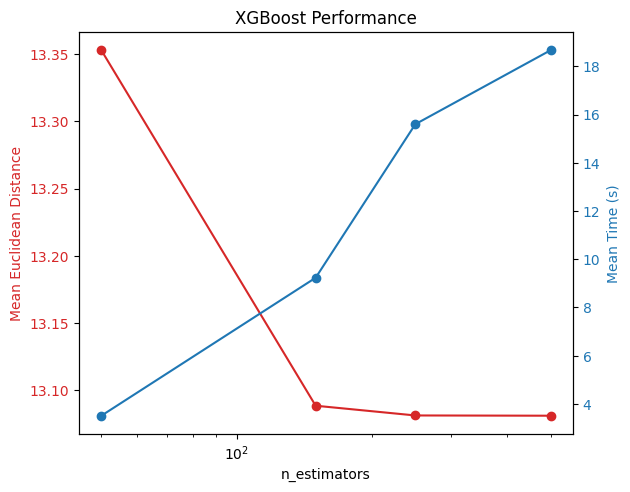

In [140]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Mean Euclidean Distance', color=color)
ax1.semilogx(n_estimators, mean_distances, '-o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Mean Time (s)', color=color)
ax2.plot(n_estimators, mean_times, '-o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('XGBoost Performance')
plt.show()

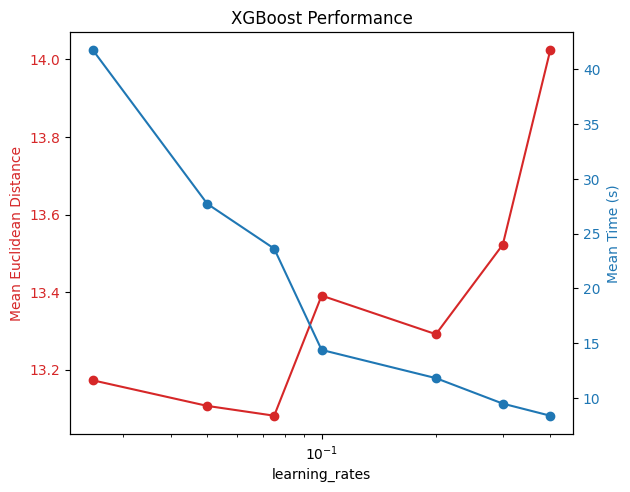

In [136]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('learning_rates')
ax1.set_ylabel('Mean Euclidean Distance', color=color)
ax1.semilogx(learning_rates, mean_distances, '-o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Mean Time (s)', color=color)
ax2.plot(learning_rates, mean_times, '-o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('XGBoost Performance')
plt.show()

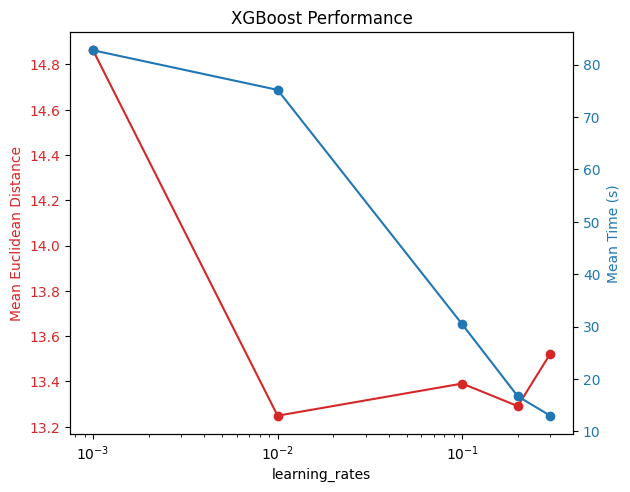

In [134]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('learning_rates')
ax1.set_ylabel('Mean Euclidean Distance', color=color)
ax1.semilogx(learning_rates, mean_distances, '-o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Mean Time (s)', color=color)
ax2.plot(learning_rates, mean_times, '-o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('XGBoost Performance')
plt.show()


In [181]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
import pandas as pd
import numpy as np

feature_columns = merged_df.columns[8:]
target_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

X = merged_df[feature_columns]

params = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.075],
    'reg_alpha': [5, 10, 15, 30],
    'objective': ['reg:squarederror'],
    'seed': [33]
}

# Create a DataFrame to store the best hyperparameters and scores for each target variable
results_df = pd.DataFrame(columns=['target_variable', 'best_parameters', 'best_score'])

for target_column in target_columns:
    print(f"Optimizing hyperparameters for {target_column}")
    y = merged_df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

    randomized_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(), param_distributions=params, n_iter=20, cv=5, random_state=33)
    randomized_search.fit(X_train, y_train)

    print(f"Best parameters for {target_column}: {randomized_search.best_params_}")
    print(f"Best score for {target_column}: {randomized_search.best_score_}\n")
    
    # Append the results to the results_df DataFrame
    new_row = {'target_variable': target_column,
            'best_parameters': randomized_search.best_params_,
            'best_score': randomized_search.best_score_}
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


# Save the results DataFrame to a CSV file
results_df.to_csv('best_hyperparameters_scores_randomized.csv', index=False)


Optimizing hyperparameters for updrs_1
Best parameters for updrs_1: {'seed': 33, 'reg_alpha': 5, 'objective': 'reg:squarederror', 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.075}
Best score for updrs_1: 0.20347305199972351

Optimizing hyperparameters for updrs_2
Best parameters for updrs_2: {'seed': 33, 'reg_alpha': 10, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.075}
Best score for updrs_2: 0.26859376214813546

Optimizing hyperparameters for updrs_3
Best parameters for updrs_3: {'seed': 33, 'reg_alpha': 10, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.075}
Best score for updrs_3: 0.2736083083807153

Optimizing hyperparameters for updrs_4
Best parameters for updrs_4: {'seed': 33, 'reg_alpha': 10, 'objective': 'reg:squarederror', 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.075}
Best score for updrs_4: 0.14217900383318588



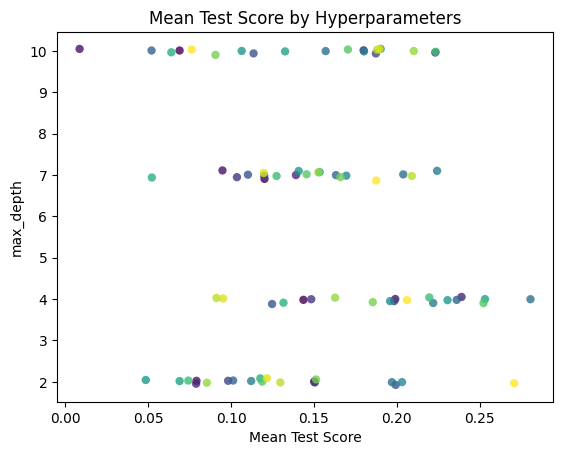

In [175]:
import matplotlib.pyplot as plt
import numpy as np

cv_df = pd.DataFrame(grid_search.cv_results_)

max_depth_values = cv_df['param_max_depth'].unique()

fig, ax = plt.subplots()

for i, max_depth in enumerate(max_depth_values):
    group = cv_df[cv_df['param_max_depth'] == max_depth]
    n_estimators = group['param_n_estimators'].values
    scores = group['mean_test_score'].values
    colors = plt.cm.viridis(np.linspace(0, 1, len(n_estimators)))
    jitter_x = np.random.normal(0, 0.05, len(n_estimators))
    jitter_y = np.random.normal(0, 0.05, len(n_estimators))
    sc = ax.scatter(scores + jitter_x, np.repeat(max_depth, len(scores)) + jitter_y, color=colors, edgecolors='none', alpha=0.8, label=f"max_depth={max_depth}")

ax.set_xlabel('Mean Test Score')
ax.set_ylabel('max_depth')
ax.set_title('Mean Test Score by Hyperparameters')
plt.show()


In [176]:
cv_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_n_estimators',
       'param_objective', 'param_reg_alpha', 'param_seed', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

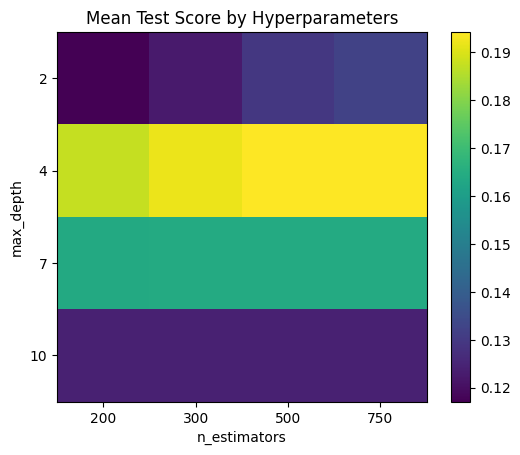

In [161]:
import matplotlib.pyplot as plt

cv_df = pd.DataFrame(grid_search.cv_results_)

scores = cv_df.pivot_table(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

fig, ax = plt.subplots()
im = ax.imshow(scores, cmap='viridis')

ax.set_xticks(np.arange(len(scores.columns)))
ax.set_yticks(np.arange(len(scores.index)))
ax.set_xticklabels(scores.columns)
ax.set_yticklabels(scores.index)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_title('Mean Test Score by Hyperparameters')

plt.colorbar(im)
plt.show()


In [162]:
first_run_cv = cv_df.copy()

# Save the dataframe as a CSV file
first_run_cv.to_csv('first_run_cv.csv', index=False)

In [164]:
first_run_cv.info

<bound method DataFrame.info of     mean_fit_time  std_fit_time  mean_score_time  std_score_time   
0        2.019029      0.349984         0.010407        0.001014  \
1        1.470901      0.160905         0.010929        0.003204   
2        1.940230      0.228388         0.009991        0.000582   
3        1.928411      0.432705         0.008919        0.000511   
4        2.217385      0.726104         0.009394        0.000871   
..            ...           ...              ...             ...   
75      11.943545      4.248645         0.010917        0.000426   
76       9.357783      0.393935         0.010949        0.000151   
77       8.698787      0.463962         0.010641        0.000576   
78       7.163161      0.228315         0.010496        0.000759   
79       5.601550      0.303527         0.009629        0.000445   

   param_learning_rate param_max_depth param_n_estimators   param_objective   
0                0.075               2                200  reg:squareder

In [143]:
feature_columns = merged_df.columns[8:]
target_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

X = merged_df[feature_columns]
y = merged_df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

n_estimators_values = [150, 200,300]
max_depth_values = [2, 4, 7, 10]
colors = ['blue', 'green', 'red']
mean_distances = []

for n_estimators in n_estimators_values:
    models = {}
    for target in target_columns:
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, max_depth=10, learning_rate=0.075, seed=33, reg_alpha=0.01)
        model.fit(X_train, y_train[target])
        models[target] = model

    # Initialize a DataFrame to store the predicted values
    y_pred_all = pd.DataFrame(index=y_test.index, columns=target_columns)

    for target, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_all[target] = y_pred

    # Compute the Euclidean distance between the predicted and actual target values for each observation
    distances = np.sqrt(np.sum((y_test.values - y_pred_all.values) ** 2, axis=1))

    # Compute the mean Euclidean distance across all observations
    mean_distance = np.mean(distances)
    mean_distances.append(mean_distance)

KeyboardInterrupt: 

In [ ]:
# Plot n_estimators vs mean Euclidean distance
plt.plot(n_estimators_values, mean_distances)
plt.xlabel('n_estimators')
plt.ylabel('Mean Euclidean Distance')
plt.title('n_estimators vs Mean Euclidean Distance')
plt.show()

# Plot MSE for all UPDRS targets
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, target in enumerate(target_columns):
    mean_mse = []
    for n_estimators in n_estimators_values:
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, max_depth=10, learning_rate=0.075, seed=33, reg_alpha=0.01)
        model.fit(X_train, y_train[target])
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test[target], y_pred)
        mean_mse.append(mse)

    # Plot the MSE scores for the target on a separate subplot
    row = i // 2
    col = i % 2
    axs[row, col].plot(n_estimators_values, mean_mse)
    axs[row, col].set_xlabel('n_estimators')
    axs[row, col].set_ylabel('MSE')
    axs[row, col].set_title(target)

plt.suptitle('MSE for all UPDRS targets')
plt.tight_layout()
plt.show()


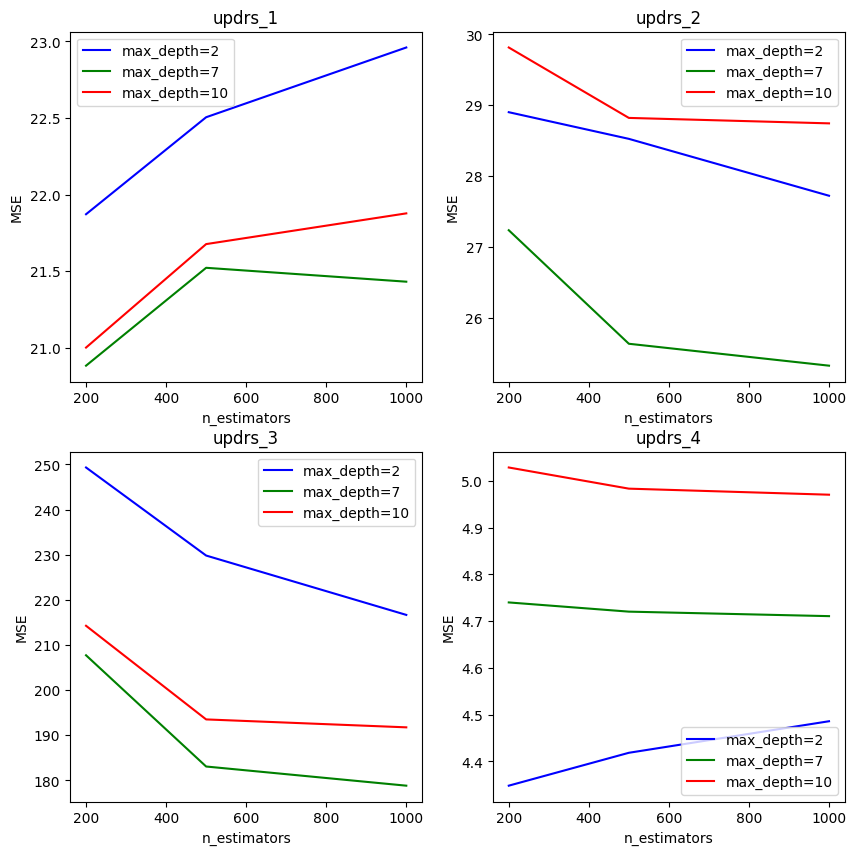

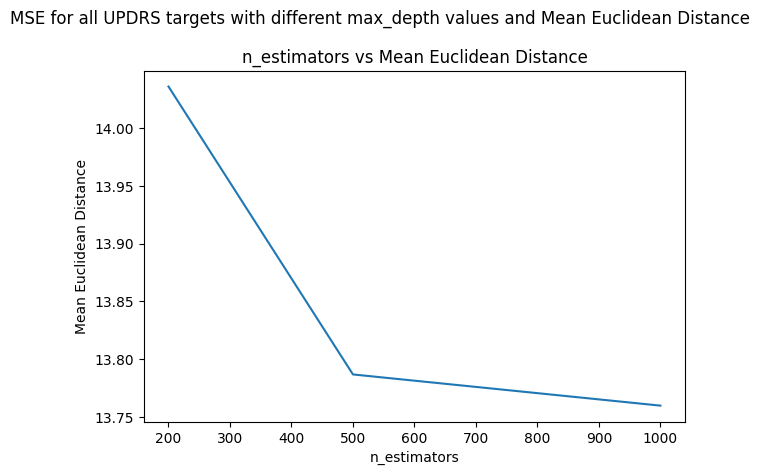

In [90]:
feature_columns = merged_df.columns[8:]
target_columns = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

X = merged_df[feature_columns]
y = merged_df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

n_estimators_values = [200, 500, 1000]
max_depth_values = [2, 7, 10]
colors = ['blue', 'green', 'red']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, target in enumerate(target_columns):
    for j, max_depth in enumerate(max_depth_values):
        mean_mse = []
        for n_estimators in n_estimators_values:
            model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, max_depth=max_depth, learning_rate=0.075, seed=33, reg_alpha=0.01)
            model.fit(X_train, y_train[target])
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test[target], y_pred)
            mean_mse.append(mse)

        # Plot the MSE scores for the target on the same subplot with different colors for each max_depth value
        row = i // 2
        col = i % 2
        axs[row, col].plot(n_estimators_values, mean_mse, color=colors[j], label=f"max_depth={max_depth}")
        axs[row, col].set_xlabel('n_estimators')
        axs[row, col].set_ylabel('MSE')
        axs[row, col].set_title(target)
        axs[row, col].legend()

# Plot the mean Euclidean distance
mean_distances = []

for n_estimators in n_estimators_values:
    models = {}
    for target in target_columns:
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, max_depth=10, learning_rate=0.075, seed=33, reg_alpha=0.01)
        model.fit(X_train, y_train[target])
        models[target] = model

    # Initialize a DataFrame to store the predicted values
    y_pred_all = pd.DataFrame(index=y_test.index, columns=target_columns)

    for target, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_all[target] = y_pred

    # Compute the Euclidean distance between the predicted and actual target values for each observation
    distances = np.sqrt(np.sum((y_test.values - y_pred_all.values) ** 2, axis=1))

    # Compute the mean Euclidean distance across all observations
    mean_distance = np.mean(distances)
    mean_distances.append(mean_distance)

mse_df = pd.DataFrame(mean_mse_values, columns=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'])
mse_df.to_csv('mse_values.csv', index=False)

euclidean_df = pd.DataFrame(mean_distances, columns=['mean_euclidean_distance'])
euclidean_df.to_csv('euclidean_distance.csv', index=False)




In [ ]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, target_mean_mse in enumerate(mean_mse_values):
    row, col = divmod(i, 2)
    for j, max_depth_mean_mse in enumerate(target_mean_mse):
        axs[row, col].plot(n_estimators_values, max_depth_mean_mse, color=colors[j], label=f"max_depth={max_depth_values[j]}")
    axs[row, col].set_xlabel('n_estimators')
    axs[row, col].set_ylabel('MSE')
    axs[row, col].set_title(target_columns[i])
    axs[row, col].legend()

# Plot n_estimators vs mean Euclidean distance
axs[1, 2].plot(n_estimators_values, mean_distances, '-o')
axs[1, 2].set_xlabel('n_estimators')
axs[1, 2].set_ylabel('Mean Euclidean Distance')
axs[1, 2].set_title('n_estimators vs Mean Euclidean Distance')

plt.tight_layout()
plt.show()


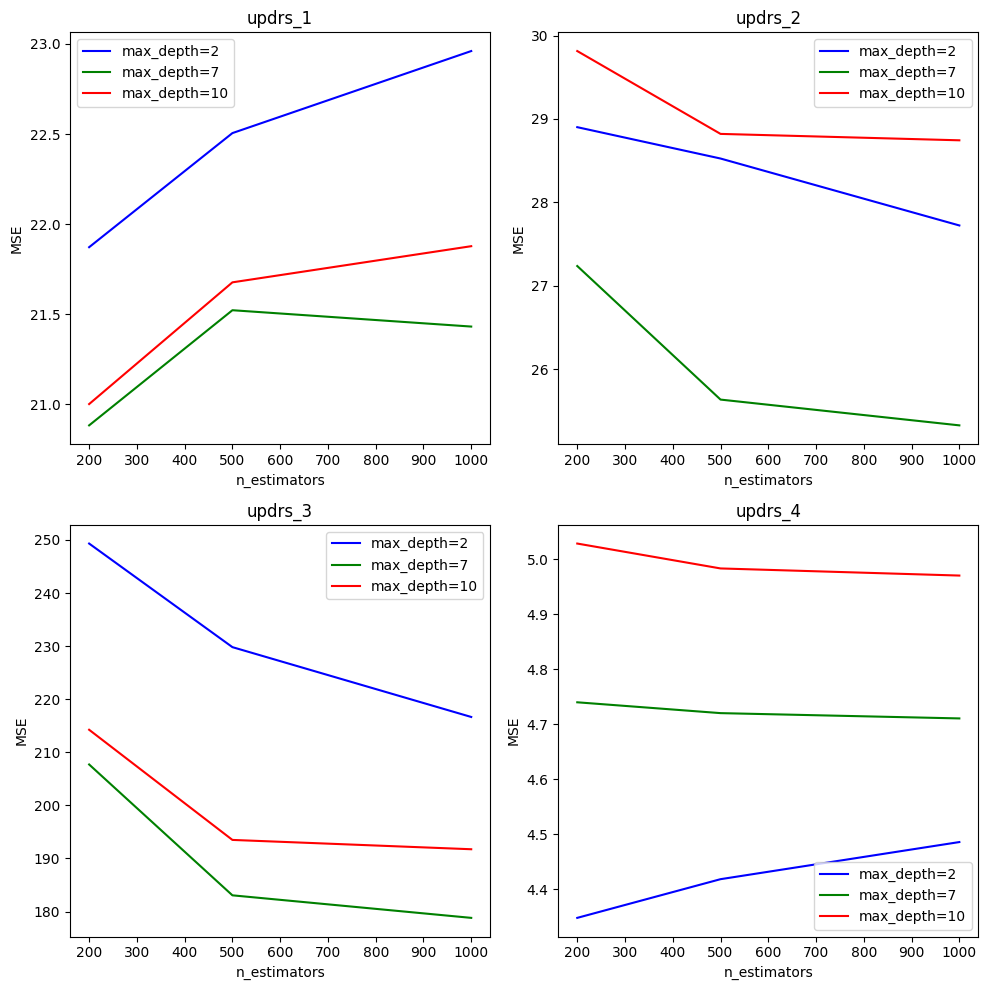

In [104]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, target_mean_mse in enumerate(mean_mse_values):
    row, col = divmod(i, 2)
    for j, max_depth_mean_mse in enumerate(target_mean_mse):
        axs[row, col].plot(n_estimators_values, max_depth_mean_mse, color=colors[j], label=f"max_depth={max_depth_values[j]}")
    axs[row, col].set_xlabel('n_estimators')
    axs[row, col].set_ylabel('MSE')
    axs[row, col].set_title(target_columns[i])
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# Save MSE and mean Euclidean distance results to CSV files
mse_df = pd.DataFrame(mean_mse_values, columns=max_depth_values, index=target_columns)
mse_df.to_csv('mse_values.csv', index=False)

euclidean_df = pd.DataFrame(mean_distances, columns=['mean_euclidean_distance'], index=n_estimators_values)
euclidean_df.to_csv('euclidean_distance.csv', index=False)


In [ ]:
## TODO compare finding each u1,u2,u3,u4 separately or singularly as a 4D tuple 

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

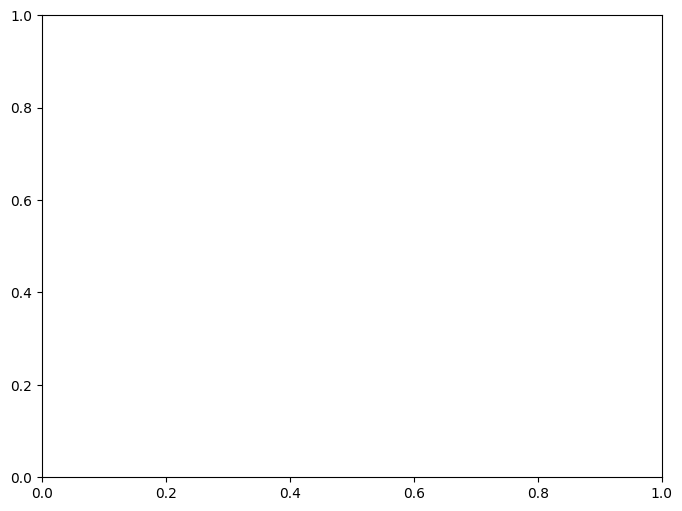

In [106]:
plt.figure(figsize=(8, 6))

for i, max_depth_mean_distances in enumerate(mean_distances):
    plt.plot(n_estimators_values, max_depth_mean_distances, marker='o', linestyle='-', color=colors[i], label=f"max_depth={max_depth_values[i]}")

plt.xlabel('n_estimators')
plt.ylabel('Mean Euclidean Distance')
plt.title('Mean Euclidean Distance vs n_estimators')
plt.legend()
plt.grid(True)
plt.show()

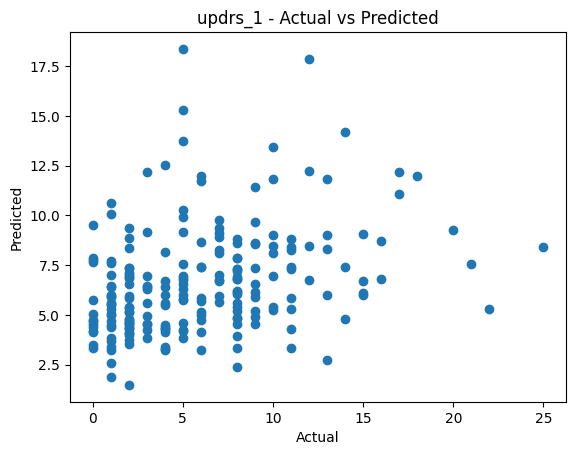

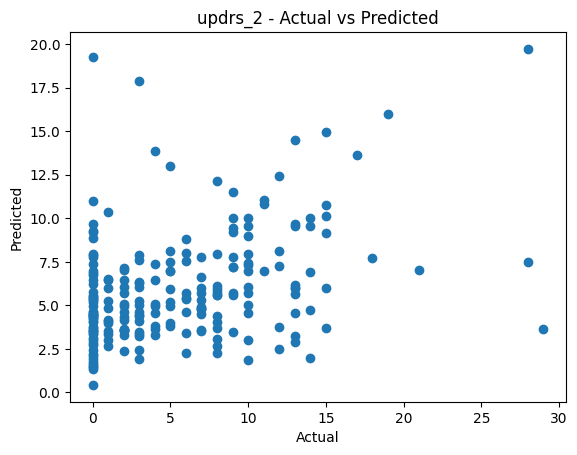

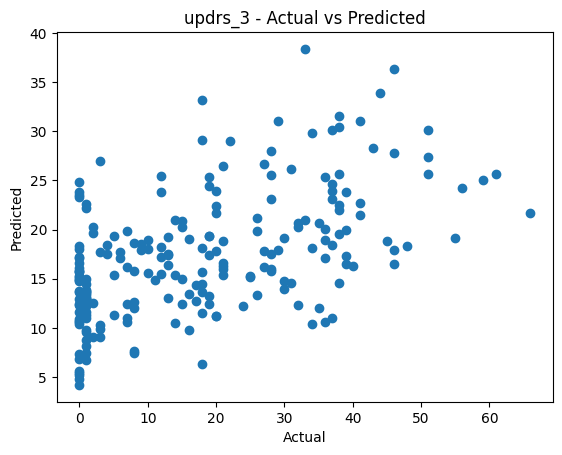

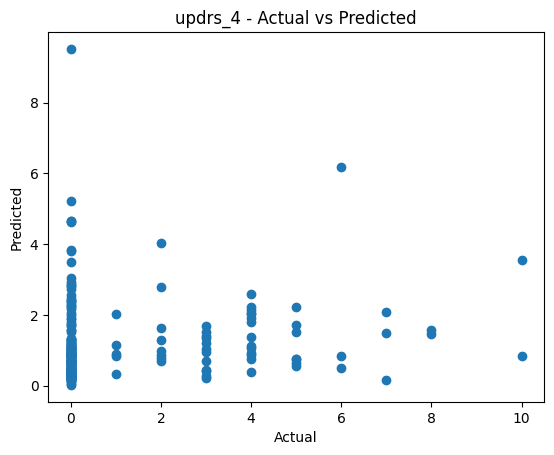

In [94]:
import matplotlib.pyplot as plt

# Combine actual and predicted values in a single DataFrame
results_df = pd.DataFrame(y_test, columns=target_columns)
for target, model in models.items():
    results_df[f'predicted_{target}'] = model.predict(X_test)

# Create a plot for each UPDRS score
for target in target_columns:
    fig, ax = plt.subplots()
    ax.scatter(results_df[target], results_df[f'predicted_{target}'])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{target} - Actual vs Predicted')
    plt.show()
